In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import random
import seaborn as sns
import optuna
from torch.utils.data import DataLoader, Dataset, TensorDataset, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from torch.cuda import amp
from optuna.samplers import TPESampler

2025-06-04 23:56:00.660708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749081360.880842      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749081360.945755      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config:
    SEED = 42
    MAX_LEN = 128  # Or 64, 256
    BATCH_SIZE = 16  # Or 16, 64
    LEARNING_RATE = 1.83e-5  # Or 2e-5, 4e-5, 5e-5
    EPOCHS = 2
    WARMUP_PROPORTION = 0.18
    GRADIENT_ACCUMULATION_STEPS = 2
    EARLY_STOPPING_PATIENCE = 2
    MODEL_NAME = 'bert-base-uncased'
    WEIGHT_DECAY = 0.024
    DROPOUT = 0.15

# ✅ Set seed for reproducibility
def set_seed(seed=Config.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [ ]:
# Files checking
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_df = pd.read_csv(os.path.join('../input', 'train_dataset.csv'))
test_df = pd.read_csv(os.path.join('../input', 'test_dataset.csv'))
val_df = pd.read_csv(os.path.join('../input', 'val_dataset.csv'))

# Check column names
print(f"Train columns: {train_df.columns}")
print(f"Test columns: {test_df.columns}")

Train columns: Index(['ID', 'Text', 'Label'], dtype='object')
Test columns: Index(['ID', 'Text'], dtype='object')


Class weights: [1.00002696 0.99997304]


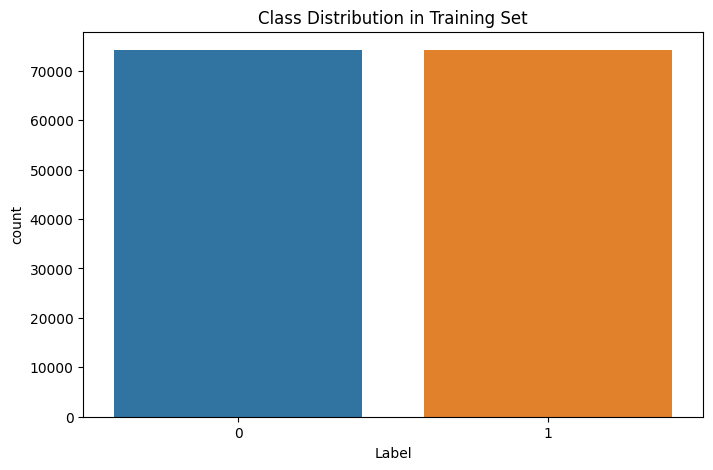

In [5]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['Label'])
weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights: {class_weights}")

# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.show()

In [6]:
# 🧹 Preprocessing
tokenizer = BertTokenizer.from_pretrained(Config.MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# # 1. Keep all your initial imports and Config class as is
# # 2. After your data loading (train_df, val_df, test_df) but BEFORE creating dataloaders:

# # ======================================================
# # 🎛️ Optuna Hyperparameter Optimization (Modified)
# # ======================================================
# def objective(trial):
#     # Suggest hyperparameters
#     params = {
#         'lr': trial.suggest_float('lr', 1e-5, 5e-5, log=True),
#         'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
#         'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
#         'dropout': trial.suggest_float('dropout', 0.1, 0.4),
#         'epochs': trial.suggest_int('epochs', 2, 5),
#         'warmup_ratio': trial.suggest_float('warmup_ratio', 0.05, 0.2)
#     }
    
#     # Initialize device (must be inside objective)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Initialize tokenizer
#     tokenizer = BertTokenizer.from_pretrained(Config.MODEL_NAME)
    
#     # Create datasets with current MAX_LEN
#     train_dataset = TweetDataset(train_df['Text'], train_df['Label'], tokenizer, Config.MAX_LEN)
#     val_dataset = TweetDataset(val_df['Text'], val_df['Label'], tokenizer, Config.MAX_LEN)
    
#     # Create data loaders with trial's batch size
#     train_loader = DataLoader(train_dataset, 
#                             batch_size=params['batch_size'], 
#                             shuffle=True)
#     val_loader = DataLoader(val_dataset, 
#                           batch_size=params['batch_size']*2)
    
#     # Initialize model with suggested dropout
#     model = BertForSequenceClassification.from_pretrained(
#         Config.MODEL_NAME,
#         num_labels=2,
#         hidden_dropout_prob=params['dropout'],
#         attention_probs_dropout_prob=params['dropout']
#     ).to(device)
    
#     # Configure loss function with class weights
#     loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    
#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), 
#                     lr=params['lr'],
#                     weight_decay=params['weight_decay'])
    
#     # Calculate total steps
#     total_steps = len(train_loader) * params['epochs']
    
#     # Configure scheduler
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=int(total_steps * params['warmup_ratio']),
#         num_training_steps=total_steps
#     )
    
#     # Training loop
#     best_val_loss = float('inf')
#     for epoch in range(params['epochs']):
#         # Train
#         model.train()
#         total_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
            
#             inputs = {
#                 'input_ids': batch['input_ids'].to(device),
#                 'attention_mask': batch['attention_mask'].to(device),
#                 'label': batch['label'].to(device)  # lowercase!
#             }
            
#             outputs = model(
#                 input_ids=inputs['input_ids'],
#                 attention_mask=inputs['attention_mask'],
#                 labels=inputs['label']  # lowercase!
#             )
#             loss = outputs.loss  # Use built-in loss calculation
#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             total_loss += loss.item()
        
#         # Validate
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 inputs = {
#                     'input_ids': batch['input_ids'].to(device),
#                     'attention_mask': batch['attention_mask'].to(device),
#                     'label': batch['label'].to(device)
#                 }
#                 outputs = model(
#                     input_ids=inputs['input_ids'],
#                     attention_mask=inputs['attention_mask'],
#                     labels=inputs['label']
#                 )
#                 val_loss += outputs.loss.item()
        
#         avg_val_loss = val_loss / len(val_loader)
#         trial.report(avg_val_loss, epoch)
        
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()
            
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
    
#     return best_val_loss

# def run_optuna_study():
#     study = optuna.create_study(
#         direction='minimize',
#         sampler=TPESampler(seed=Config.SEED)
#     )
#     study.optimize(objective, n_trials=5)  # Start with 5 trials
    
#     print("Best trial:")
#     trial = study.best_trial
#     print(f"Validation Loss: {trial.value:.4f}")
#     print("Best Params:")
#     for key, value in trial.params.items():
#         print(f"{key:15}: {value}")
    
#     return study

# # ======================================================
# # 🔍 Run Optuna Study (Uncomment to run)
# # ======================================================
# study = run_optuna_study()
# best_params = study.best_trial.params

# # After finding best params, update your Config:
# Config.BATCH_SIZE = best_params['batch_size']
# Config.LEARNING_RATE = best_params['lr']
# Config.WEIGHT_DECAY = best_params['weight_decay']
# Config.EPOCHS = best_params['epochs']
# Config.WARMUP_PROPORTION = best_params['warmup_ratio']
# dropout = best_params['dropout']

# # ======================================================
# # THEN proceed with your original dataloaders and training
# # using the optimized parameters

In [8]:
# ✅ Dataloaders
train_dataset = TweetDataset(train_df['Text'], train_df['Label'], tokenizer, Config.MAX_LEN)
val_dataset = TweetDataset(val_df['Text'], val_df['Label'], tokenizer, Config.MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE*2)

In [9]:
# 🧠 Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BertForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=Config.DROPOUT,
    attention_probs_dropout_prob=Config.DROPOUT
)

loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(device))
model.config.class_weight = weights.to(device)  

model.to(device)

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.15, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [10]:
# ⚙️ Optimizer
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, eps=1e-8, weight_decay=Config.WEIGHT_DECAY)

In [11]:
# ⏳ Scheduler setup
total_steps = len(train_loader) * Config.EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(Config.WARMUP_PROPORTION * total_steps),
    num_training_steps=total_steps
)

# Mixed precision training
scaler = torch.amp.GradScaler()

In [12]:
# 🕒 Format time helper
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [13]:
# 🔁 Training loop
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    t0 = time.time()
    
    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        with amp.autocast():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss_fct = torch.nn.CrossEntropyLoss(weight=model.config.class_weight)
            loss = loss_fct(outputs.logits, b_labels) / Config.GRADIENT_ACCUMULATION_STEPS
        
        scaler.scale(loss).backward()
        total_loss += loss.item() * Config.GRADIENT_ACCUMULATION_STEPS
        
        if (step + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

    avg_loss = total_loss / len(dataloader)
    training_time = format_time(time.time() - t0)
    return avg_loss, training_time

In [14]:
# 🎯 Evaluation loop
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    total_loss = 0
    t0 = time.time()

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['label'].to(device)

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            true_labels += b_labels.cpu().tolist()

    acc = accuracy_score(true_labels, preds)
    prec, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='binary')
    avg_loss = total_loss / len(dataloader)
    validation_time = format_time(time.time() - t0)

    return acc, prec, recall, f1, avg_loss, validation_time, preds

In [15]:
# 🚀 Run training
training_stats = [] # 📈 Track training stats
best_val_loss = float('inf')
trigger_times = 0
best_model_path = 'best_model.pt'

total_t0 = time.time()

for epoch in range(Config.EPOCHS):
    print(f"\n======== Epoch {epoch + 1} / {Config.EPOCHS} ========")

    train_loss, train_time = train_epoch(model, train_loader, optimizer, scheduler)
    acc, prec, recall, f1, val_loss, val_time, _ = evaluate(model, val_loader)

    print(f"\n✅ Train Loss: {train_loss:.4f} | ⏱️ Time: {train_time}")
    print(f"✅ Val   Loss: {val_loss:.4f} | ⏱️ Time: {val_time}")
    print(f"📊 Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("💾 Saved best model!")
    else:
        trigger_times += 1
        if trigger_times >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered!")
            break

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': train_loss,
        'Validation Loss': val_loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': recall,
        'F1 Score': f1,
        'Training Time': train_time,
        'Validation Time': val_time
    })

print("\nTraining complete!")
print(f"Total training took: {format_time(time.time() - total_t0)}")

# Load best model
model.load_state_dict(torch.load(best_model_path))


======== Epoch 1 / 2 ========


Training:   0%|          | 0/9275 [00:00<?, ?it/s]/tmp/ipykernel_31/4254156469.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training: 100%|██████████| 9275/9275 [28:49<00:00,  5.36it/s]



✅ Train Loss: 0.4389 | ⏱️ Time: 0:28:49
✅ Val   Loss: 0.3603 | ⏱️ Time: 0:02:38
📊 Acc: 0.8414 | Prec: 0.8368 | Recall: 0.8483 | F1: 0.8425
💾 Saved best model!

======== Epoch 2 / 2 ========


Training:   0%|          | 0/9275 [00:00<?, ?it/s]/tmp/ipykernel_31/4254156469.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training: 100%|██████████| 9275/9275 [28:50<00:00,  5.36it/s]



✅ Train Loss: 0.3476 | ⏱️ Time: 0:28:51
✅ Val   Loss: 0.3462 | ⏱️ Time: 0:02:38
📊 Acc: 0.8495 | Prec: 0.8605 | Recall: 0.8342 | F1: 0.8472
💾 Saved best model!

Training complete!
Total training took: 1:02:59


<All keys matched successfully>

In [16]:
# 📊 Display training stats as a table
df_stats = pd.DataFrame(training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Training Time,Validation Time
epoch,,,,,,,,
1,0.438884,0.360272,0.841424,0.836808,0.848295,0.842512,0:28:49,0:02:38
2,0.347615,0.346210,0.849514,0.860542,0.834237,0.847186,0:28:51,0:02:38


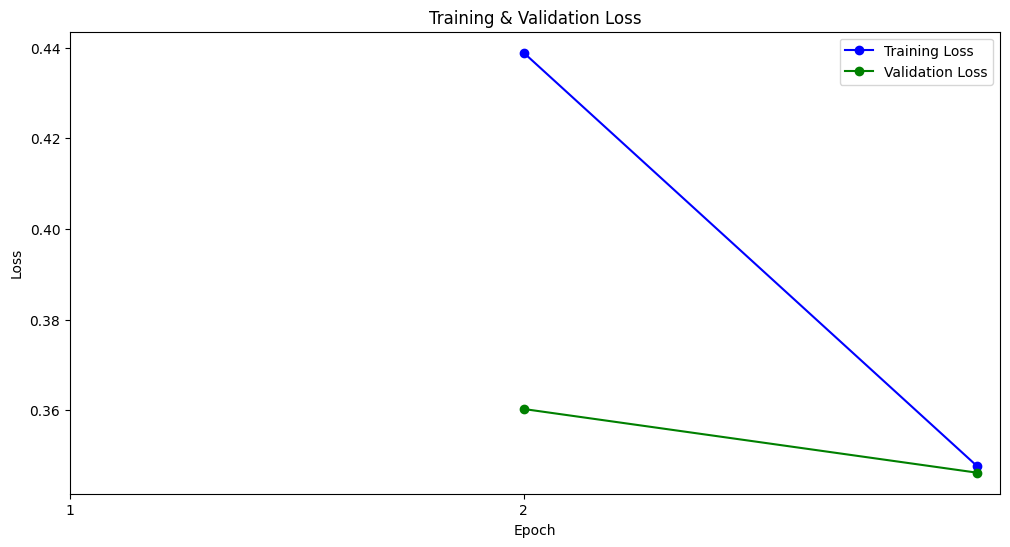

In [17]:
# 📉 Plot training & validation loss
plt.figure(figsize=(12,6))
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(len(df_stats)), df_stats.index)
plt.show()

In [18]:
# 🧪 Create test DataLoader (no labels)
test_dataset = TweetDataset(test_df['Text'], pd.Series([0]*len(test_df)), tokenizer, Config.MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

In [19]:
# 🔍 Predict
model.eval()
all_preds = []

print(f'🔮 Predicting sentiment for {len(test_df)} tweets...')

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

print("✅ Prediction complete.")

🔮 Predicting sentiment for 21199 tweets...


Predicting: 100%|██████████| 1325/1325 [01:21<00:00, 16.30it/s]

✅ Prediction complete.


In [20]:
# 📤 Save predictions with IDs
submission_df = pd.DataFrame({'ID': test_df['ID'],'Predicted': all_preds})
submission_df.to_csv("submission.csv", index=False)
print("📁 Submission file saved as 'submission.csv'")

# Show sample
display(submission_df.head())

📁 Submission file saved as 'submission.csv'


,ID,Predicted
0,102388,1
1,153802,0
2,61831,0
3,18317,1
4,50061,1
